In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from src.layers.gnn import MegNetBlock, Flatten, MegNet
from src.layers.dense import Dense
from src.activations import Relu, Linear, Sigmoid
from src.losses import MSE, MAE
from src.optimizers import Adam

In [2]:
import pickle

with open(r'src\dataset\bonded_structures_pandas_dataframe.pkl', 'rb') as f:
        X = pickle.load(f)

y = X['targets']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [4]:
ATOM_ENCODING = {
    "Mo": [1, 0, 0, 0],
    "S": [0, 1, 0, 0],
    "Se": [0, 0, 1, 0],
    "W": [0, 0, 0, 1],
}
NODE_FEATURES = 7  # 4 для типа атома + 3 для координат
EDGE_FEATURES = 4  # 1 для веса + 3 для to_jimage

def prepare_graph_features(
    bonded_structures: pd.Series,
):
    """Подготовка признаков для графовой нейронной сети."""
    nodes_data = []
    edges_data = []
    edges_index = []
    global_features = []

    for crystal in bonded_structures:
        crystal_nodes = [
            [*ATOM_ENCODING[node_data["specie"]], *node_data["coords"]]
            for _, node_data in crystal.graph.nodes(data=True)
        ]
        nodes_data.append(crystal_nodes)

        crystal_edges = []
        crystal_edge_indices = []
        for src, dst, edge_data in crystal.graph.edges(data=True):
            crystal_edges.append([edge_data["weight"], *edge_data["to_jimage"]])
            crystal_edge_indices.append([src, dst])

        edges_data.append(crystal_edges)
        edges_index.append(crystal_edge_indices)

        global_features.append(
            [
                crystal.structure.lattice.a,
                crystal.structure.lattice.b,
                crystal.structure.lattice.c,
                crystal.structure.lattice.alpha,
                crystal.structure.lattice.beta,
                crystal.structure.lattice.gamma,
                # crystal.structure.lattice.volume,
                crystal.structure.lattice.pbc[0],
                crystal.structure.lattice.pbc[1],
                crystal.structure.lattice.pbc[2],
                crystal.structure.lattice.matrix[0][0],
                crystal.structure.lattice.matrix[0][1],
                crystal.structure.lattice.matrix[0][2],
                crystal.structure.lattice.matrix[1][0],
                crystal.structure.lattice.matrix[1][1],
                crystal.structure.lattice.matrix[1][2],
                crystal.structure.lattice.matrix[2][0],
                crystal.structure.lattice.matrix[2][1],
                crystal.structure.lattice.matrix[2][2],
            ]
        )

    # Паддинг данных
    max_nodes = max(len(nodes) for nodes in nodes_data)
    max_edges = max(len(edges) for edges in edges_data)

    # Паддинг для каждого типа данных
    for node in nodes_data:
        node.extend([[0] * NODE_FEATURES] * (max_nodes - len(node)))
    for edge in edges_data:
        edge.extend([[0] * EDGE_FEATURES] * (max_edges - len(edge)))
    for edge_index in edges_index:
        edge_index.extend([[0, 0]] * (max_edges - len(edge_index)))

    return (
        np.array(nodes_data),
        np.array(edges_data),
        np.array(global_features),
        np.array(edges_index),      
    )


In [5]:
X_train_graph = prepare_graph_features(X_train['bonded_structures'])
X_test_graph = prepare_graph_features(X_test['bonded_structures'])

In [6]:
from sklearn.preprocessing import StandardScaler

def normalize_graph_features(X_train_batch, X_test_batch):
    """
    Нормализует узлы, рёбра, глобальные признаки и индексы рёбер.
    
    Параметры:
    ----------
    X_train_batch : tuple из 4 np.array
        - nodes:    (B, N, node_features)
        - edges:    (B, E, edge_features)
        - global_u: (B, u_features)
        - edge_idx: (B, E, 2)  # индексы (v_s, v_r) рёбер
    
    X_test_batch : tuple из 4 np.array
        Те же размеры, что и у X_train_batch.
    
    Возвращает:
    -----------
    normalized_train : tuple из 4 np.array
        Нормализованные тренировочные данные.
    normalized_test : tuple из 4 np.array
        Нормализованные тестовые данные.
    """
    nodes_train, edges_train, global_u_train, edge_idx_train = X_train_batch
    nodes_test, edges_test, global_u_test, edge_idx_test = X_test_batch

    # Узлы
    nodes_scaler = MinMaxScaler()
    nodes_shape = nodes_train.shape
    nodes_train_flat = nodes_train.reshape(-1, nodes_train.shape[-1])
    nodes_test_flat = nodes_test.reshape(-1, nodes_test.shape[-1])
    nodes_train_scaled = nodes_scaler.fit_transform(nodes_train_flat)
    nodes_test_scaled = nodes_scaler.transform(nodes_test_flat)
    nodes_train = nodes_train_scaled.reshape(nodes_shape)
    nodes_test = nodes_test_scaled.reshape(nodes_test.shape)

    # Рёбра
    edges_scaler = MinMaxScaler()
    edges_shape = edges_train.shape
    edges_train_flat = edges_train.reshape(-1, edges_train.shape[-1])
    edges_test_flat = edges_test.reshape(-1, edges_test.shape[-1])
    edges_train_scaled = edges_scaler.fit_transform(edges_train_flat)
    edges_test_scaled = edges_scaler.transform(edges_test_flat)
    edges_train = edges_train_scaled.reshape(edges_shape)
    edges_test = edges_test_scaled.reshape(edges_test.shape)

    # Глобальные признаки
    global_u_scaler = MinMaxScaler()
    global_u_train = global_u_scaler.fit_transform(global_u_train)
    global_u_test = global_u_scaler.transform(global_u_test)

    # Собираем обратно нормализованные данные
    normalized_train = (nodes_train, edges_train, global_u_train, edge_idx_train)
    normalized_test = (nodes_test, edges_test, global_u_test, edge_idx_test)

    return normalized_train, normalized_test

# Пример использования
X_train_normalized, X_test_normalized = normalize_graph_features(X_train_graph, X_test_graph)


In [7]:
scaler = MinMaxScaler()
y_train_graph = y_train.to_numpy().reshape(-1, 1)
y_train_graph = scaler.fit_transform(y_train_graph)

y_test_graph = y_test.to_numpy().reshape(-1, 1)
y_test_graph = scaler.transform(y_test_graph)


In [8]:
# X_train_batch = X_train_normalized
# X_test_batch = X_test_normalized
# y_train_batch = y_train_graph
# y_test_batch = y_test_graph

In [9]:
BATCH_SIZE = 1280
X_train_batch = tuple([X_train_normalized[i][:BATCH_SIZE] for i in range(len(X_train_graph))])
X_test_batch = tuple([X_test_normalized[i][:BATCH_SIZE] for i in range(len(X_train_graph))])
y_train_batch = y_train_graph[:BATCH_SIZE]
y_test_batch = y_test_graph[:BATCH_SIZE]

In [10]:
class Sequential:
    def __init__(self, *layers):
        self.layers = list(layers)
        self.is_compiled = False
        self.history = {
            'loss': [],
        }

    def compile(self, batch_size, dense_input, megnet_counts):
        """
        Параметры:
        ----------
        batch_size : int
            Размер батча.
        dense_input : tuple (node_features, edge_features, u_features)
            Число фич на узлах, рёбрах и глобальном признаке, которые
            передаются в MegNetBlock.compile(...).
        megnet_counts : tuple (node_count, edge_count)
            Число узлов и рёбер для MegNetBlock.compile(...).

        Пример: self.compile(
                     batch_size=B,
                     dense_input=(node_features, edge_features, u_features),
                     megnet_counts=(N, E)
                 )
        """

        self.is_compiled = True
        # Упаковываем в кортеж (batch_size, (n_in_node, n_in_edge, n_in_u), (node_count, edge_count))
        input_info = (batch_size, dense_input, megnet_counts)

        for layer in self.layers:
            if hasattr(layer, 'compile'):
                # Если это MegNetBlock, Flatten или Dense со своим compile
                # — вызываем compile и получаем "обновлённую" форму на выход
                # (у MegNetBlock возвращается тот же формат: (batch_size, (..), (..))
                if isinstance(layer, (MegNetBlock, Flatten, MegNet)):
                    input_info = layer.compile(*input_info)
                if isinstance(layer, Dense):
                    input_info = layer.compile(input_info)
            else:
                # Если у слоя нет compile — пропускаем
                pass

    def _feedforward(self, X):
        """
        X — либо (nodes, edges, u, node_idx) при первом MegNetBlock,
        либо (B, n_features), если это уже после Flatten и т.д.
        """
        out = X
        for layer in self.layers:
            # MegNetBlock получает 4 аргумента: forward(nodes, edges, u, node_idx)
            if isinstance(layer, MegNetBlock):
                out = layer.forward(*out)
            else:
                # Flatten, Dense и т.д. получают один "out"
                out = layer.forward(out)
        return out

    def _backprop(self, grad):
        """
        grad может быть:
         - (d_nodes, d_edges, d_u, node_idx), если последний слой — MegNetBlock,
         - (B, n_features), если последний слой — Dense,
         - и т.д.
        """
        backward_grad = grad
        for layer in reversed(self.layers):
            if isinstance(layer, MegNetBlock):
                backward_grad = layer.backward(*backward_grad)
            else:
                backward_grad = layer.backward(backward_grad)
        return backward_grad

    def fit(
        self,
        X,  # (nodes, edges, u, node_idx)
        y,
        loss_function,
        optimizer,
        epochs=10,
        lr=0.001,
        batch_size=16
    ):
        """
        X = (nodes, edges, u, node_idx)
          nodes.shape = (B, N, node_features)
          edges.shape = (B, E, edge_features)
          u.shape     = (B, u_features)
          node_idx.shape = (B, E, 2)

        y = ваша целевая метка или вектор (B, num_outputs)
        loss_function = класс с методами loss_function(...) и loss_function.backward(...)
        optimizer = класс, например, Adam(self.layers, lr=...)
        epochs = число эпох обучения
        lr = learning_rate
        """

        nodes, edges, global_u, node_idx = X
        total_samples = nodes.shape[0]

        # 1) Если нужно, компилируем (инициализируем слои), берём N, E, и т.д. из всего датасета
        #    но укажем в compile batch_size = batch_size (т.е. фиксированный).
        node_count = nodes.shape[1]
        edge_count = edges.shape[1]
        node_features = nodes.shape[-1]
        edge_features = edges.shape[-1]
        u_features = global_u.shape[-1]

        if not self.is_compiled:
            self.compile(
                batch_size=batch_size,
                dense_input=(node_features, edge_features, u_features),
                megnet_counts=(node_count, edge_count)
            )

        # 2) Инициализируем оптимизатор
        opt = optimizer(self.layers, lr)


        for epoch in range(epochs):
            # Перемешиваем индексы
            indices = np.arange(total_samples)
            np.random.shuffle(indices)

            epoch_loss = 0.0
            # Проходимся по батчам
            for start_idx in range(0, total_samples, batch_size):
                end_idx = start_idx + batch_size
                batch_idx = indices[start_idx:end_idx]
                # Формируем мини-батч
                X_batch = (
                    nodes[batch_idx],      # (batch_size, N, node_features)
                    edges[batch_idx],      # (batch_size, E, edge_features)
                    global_u[batch_idx],   # (batch_size, u_features)
                    node_idx[batch_idx],   # (batch_size, E, 2)
                )
                y_batch = y[batch_idx]   # (batch_size, ...)

                # Forward
                y_pred = self._feedforward(X_batch)

                # Считаем лосс
                loss = loss_function(y_true=y_batch, y_pred=y_pred)
                # Накапливаем лосс по батчу
                epoch_loss += loss * len(batch_idx)

                # Backward
                dloss = loss_function.backward()  
                self._backprop(dloss)

                # Шаг оптимизатора
                opt.step()

            # Усредняем лосс за эпоху (если хотим именно средний лосс)
            epoch_loss /= total_samples
            self.history['loss'].append(epoch_loss)
            print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.6f}")
        # 4) Тренировочный цикл
        # for epoch in range(epochs):
        #     # Forward
        #     y_pred = self._feedforward(X)
            
        #     # Считаем лосс
        #     # print(f'{y.shape=},{y_pred.shape=}')
        #     loss = loss_function(y_true=y, y_pred=y_pred)

        #     # Backward (вычисляем dL/dOut)
        #     dloss = loss_function.backward()

        #     self._backprop(dloss)

        #     # Шаг оптимизации
        #     opt.step()

        #     # Логгирование
        #     self.history['loss'].append(loss)
        #     print(f'Epoch {epoch+1}/{epochs} | Loss: {loss:.6f}')

    def predict(self, X):
        return self._feedforward(X)

In [11]:
# model = Sequential(
#     MegNetBlock(hidden_units=24, megnet_output_sizes=(12, 24, 6)),
#     MegNetBlock(hidden_units=12, megnet_output_sizes=(6, 12, 3)),
#     Flatten(),
#     Dense(units=64, activation=Relu()),
#     Dense(units=32, activation=Relu()),
#     Dense(units=1, activation=Sigmoid())
# )
# model.fit(
#     X=X_train_batch, 
#     y=y_train_batch, 
#     loss_function=MAE(), 
#     optimizer=Adam,
#     lr = 1e-4,
#     epochs=300
#     )

In [12]:
model = Sequential(
    MegNetBlock(hidden_units=24, megnet_output_sizes=(12, 24, 6)),
    MegNetBlock(hidden_units=12, megnet_output_sizes=(6, 12, 3)),
    Flatten(),
    Dense(units=74, activation=Relu()),
    Dense(units=42, activation=Relu()),
    Dense(units=1, activation=Sigmoid())
)
model.fit(
    X=X_train_normalized, 
    y=y_train_graph, 
    loss_function=MAE(), 
    optimizer=Adam,
    lr = 5e-4,
    epochs=6
    )

Epoch 1/6 | Loss: 0.273437
Epoch 2/6 | Loss: 0.266029
Epoch 3/6 | Loss: 0.218376
Epoch 4/6 | Loss: 0.047846
Epoch 5/6 | Loss: 0.026944
Epoch 6/6 | Loss: 0.023340


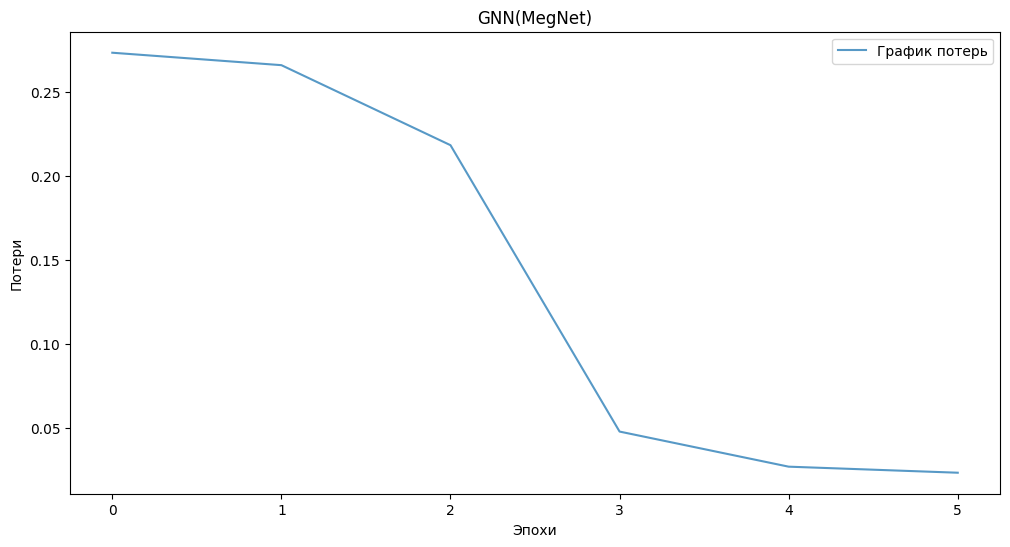

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(model.history['loss'], label="График потерь", alpha=0.75)
plt.title("GNN(MegNet)")
plt.xlabel("Эпохи")
plt.ylabel("Потери")
plt.legend()
plt.show()

In [19]:
y_pred = model.predict(X_test_normalized)
print(f'R2 score: {r2_score(y_test_graph, y_pred)}')

R2 score: 0.9768753942768854


In [20]:
y_pred_train = model.predict(X_train_batch)

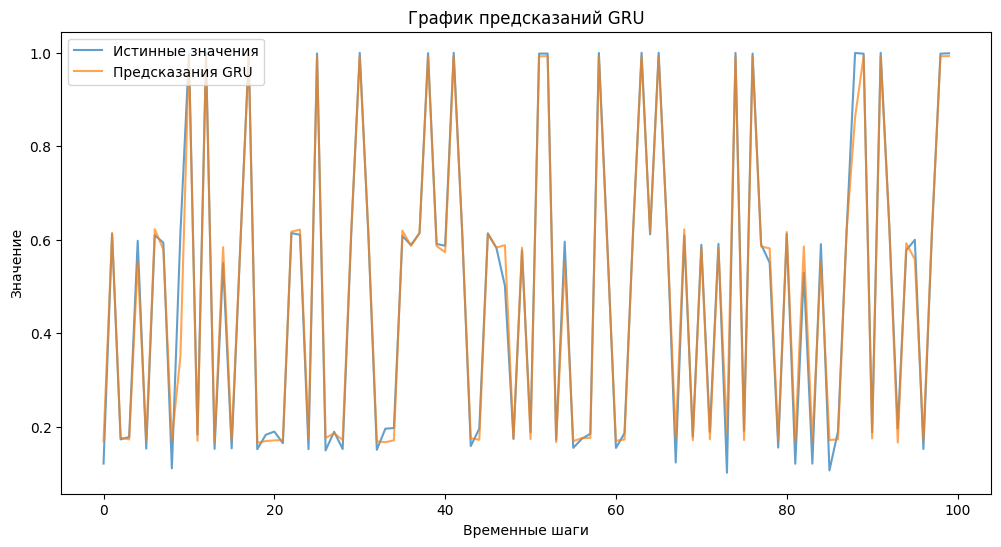

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(y_train_graph[:100], label="Истинные значения", alpha=0.7)
plt.plot(y_pred_train[:100], label="Предсказания GRU", alpha=0.7)
plt.title("График предсказаний GRU")
plt.xlabel("Временные шаги")
plt.ylabel("Значение")
plt.legend()
plt.show()

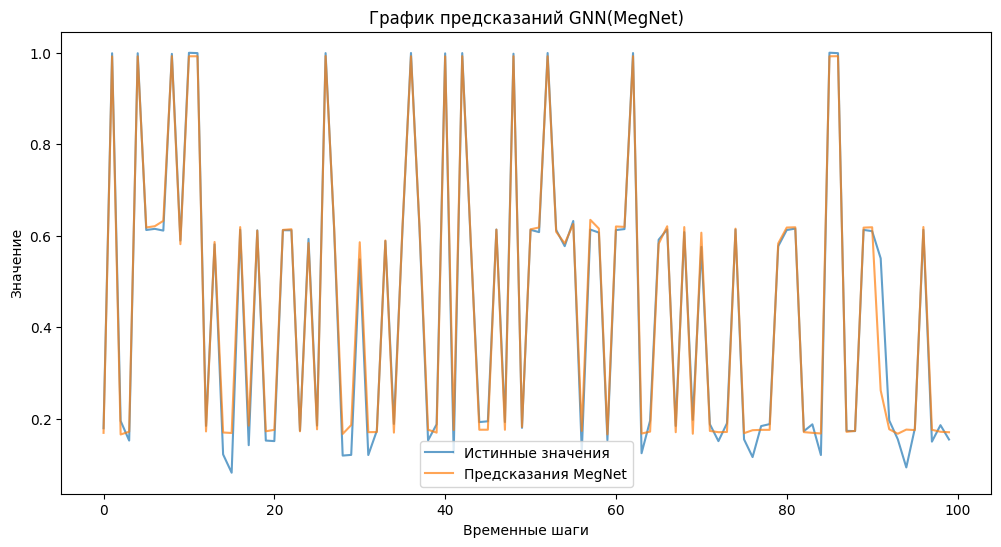

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_graph[:100], label="Истинные значения", alpha=0.7)
plt.plot(y_pred[:100], label="Предсказания MegNet", alpha=0.7)
plt.title("График предсказаний GNN(MegNet)")
plt.xlabel("Временные шаги")
plt.ylabel("Значение")
plt.legend()
plt.show()